/tmp/ipykernel_4105244/3633601136.py:23: RuntimeWarning: divide by zero encountered in divide
  z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
/tmp/ipykernel_4105244/3633601136.py:23: RuntimeWarning: invalid value encountered in divide
  z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
/tmp/ipykernel_4105244/3633601136.py:50: RuntimeWarning: divide by zero encountered in divide
  Lp = P/(rho*a)
/tmp/ipykernel_4105244/3633601136.py:67: RuntimeWarning: invalid value encountered in sqrt
  Ldiff = np.sqrt(nu*deltat)
/tmp/ipykernel_4105244/3633601136.py:68: RuntimeWarning: divide by zero encountered in divide
  vdiff = nu/Lp # local estimate of diffusion speed of energy though fluid.
/tmp/ipykernel_4105244/3633601136.py:78: RuntimeWarning: invalid value encountered in sqrt
  Ldiff_corr = np.sqrt(nu*deltat * factors)
/tmp/ipykernel_4105244/3633601136.py:97: RuntimeWarning: invalid value encountered in log10
  ax.scatter(np.log10(deltat), np.log10(Ldiff/Lgeom), c=which, s=5, marker='x', cmap=cmp)
/tmp/ipykerne

ValueError: max() arg is an empty sequence

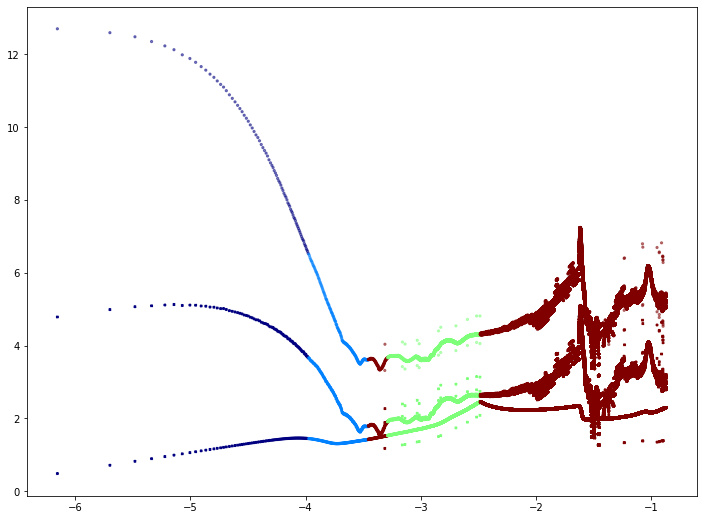

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.patches as mpatches

import scipy.integrate as si

def integrate2(x,y):
    ''' integrate2 is cumulative integral(y)dx formatted as [0, cumtrapz(y,x)]: same size as input. ''' 
    return np.hstack([0,si.cumtrapz(y,x)])
    #return si.cumtrapz(y,x)    
    
def integral2(x,y):
    ''' integral2 is total integral(y)dx computed using trapz(y,x). Consider using simps instead. ''' 
    return si.trapz(y,x) 

def mydiff(x,y):
    ''' mydiff(x,y) returns second-order difference dy/dx except at ends (1st-order): same size as input. ''' 
    z = y*0.
    z[0] = (y[1]-y[0])/(x[1]-x[0])
    z[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
    w = np.arange(1,len(z)-1)
    z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
    return z

# plt.style.use(["presentation"])  # a set of rules to make plots presentable by default (large font, etc.)
# (requires special matplotlib style file. see: 
#     https://matplotlib.org/stable/tutorials/introductory/customizing.html#using-style-sheets )


filename = r'../../project_1/big_runs/round_6/coy_2/tracked_cell_40_97.txt'
idx, t, x, y, vx,vy,rho, P = np.loadtxt(filename,delimiter=',').transpose()
# code properties 
E = 1 
dr0 = .0025 # initial res: 1/200. 


r = np.sqrt(x**2+y**2)

# characteristic length scale: max of (initial depth, current distance from surface)
Lgeom = np.maximum(np.abs(r-1), 1-r[0])  

# another characteristic length scale: pressure scale height L_p =  P/|grad P| 
# which we can evaluate from    rho a = - grad(P)
#                      so P/|grad(P)| = |P/(rho*a)| 
# so start by obtaining acceleration field
ax = mydiff(t,vx)
ay = mydiff(t,vy)
a = np.sqrt(ax**2 + ay**2)
Lp = P/(rho*a)

v = np.sqrt(vx**2+vy**2)
distance = np.sqrt((x-x[0])**2 + (y-y[0])**2) 

gamma = 4./3
s = P/rho**gamma

# estimate when the cell is hit, define as t0
t0a = np.max(t[(s<.01)]); 
t0b = np.min(t[(s>.01)]); 
t0 = np.mean((t0a,t0b));
deltat = t - t0
c,kappa = 1.,1. # placeholder definitions to keep expressions physical. 

nu = c/(3*kappa*rho)  # diffusivity 
# use diffusivity to get instaneous estimate of the diffusion length
Ldiff = np.sqrt(nu*deltat)
vdiff = nu/Lp # local estimate of diffusion speed of energy though fluid.  
    # note, vdiff/v = nu/(Lp v) is like 1/(Reynolds number)

# this can be improved using the history of the diffusivity...  start calc only when shock arrives
w = deltat>0
factor = integrate2(deltat[w],rho[w]**(-1./3))/(deltat[w]*rho[w]**(-1./3))
# 'factor' is a correction factor to account for past variations of nu because of changes in rho. 
#... incorporate this into a correction factor that is 1 before the shock arrives. 
factors = t*0+1.; factors[w]=factor;  
# and use this to make a corrected version of the diffusion length 
Ldiff_corr = np.sqrt(nu*deltat * factors)

# Define masks for the phases of evolution 0-4: 
w0 = (distance<.1*dr0)
w1 = (~w0)*(distance<3*dr0)#*(t<max(t[a>max(a)/2])) 
w2 = (~w0)*(~w1)*(np.abs(r-1) < 1-r[0])
w3 = (~w0)*(~w1)*(~w2)*(vy<0) * (t<(min(t[vy==min(vy)]) ) )
w4 = (~w0)*(~w1)*(~w2)*(~w3)
which = t*0-1; 
which[w0]=0
which[w1]=1
which[w2]=2
which[w3]=3
which[w4]=4

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
# Plot diffusion properties in each phase, and report on the comparison between the middle of phase 2 and the end of phase 3: 
cmp = 'jet'
ax.scatter(np.log10(deltat), np.log10(Ldiff/Lgeom), c=which, s=5, marker='x', cmap=cmp)
#ax.scatter(np.log10(deltat), np.log10(Ldiff_corr/Lgeom), c=which, s=0.5, alpha=0.5, cmap=cmp)


ax.scatter(np.log10(deltat), np.log10(Ldiff/Lp),s=5, c=which, marker='x', cmap=cmp)
#ax.scatter(np.log10(deltat), np.log10(Ldiff_corr/Lp),s=0.5, c=which, alpha=0.5, cmap=cmp)


ax.scatter(np.log10(deltat), np.log10(vdiff/v), c=which, s=5, alpha=0.5, cmap=cmp)

#ax.plot(np.log10(deltat), np.log10(s),':y', linewidth=0.5) 

wr0 = (np.abs(1-r) == min(np.abs(1-r)) )
wEnd3 = (t == max(t[w3]))
print('r=0: \n log Ldiff/Lgeom =',np.log10(Ldiff[wr0]/Lgeom[wr0]), '; log Ldiff/Lp =',np.log10(Ldiff[wr0]/Lp[wr0]),
      '; log10(vdiff/v)=', np.log10(vdiff[wr0]/v[wr0]))
print('end phase 3: \n Ldiff/Lgeom =',np.log10(Ldiff[wEnd3]/Lgeom[wEnd3]), '; log Ldiff/Lp =',np.log10(Ldiff[wEnd3]/Lp[wEnd3]),
      '; log10(vdiff/v)=', np.log10(vdiff[wEnd3]/v[wEnd3]))
print('ratios: \n Lgeom =', np.log10(Ldiff[wEnd3]/Lgeom[wEnd3])/np.log10(Ldiff[wr0]/Lgeom[wr0]), '; Lp =', 
      np.log10(Ldiff[wEnd3]/Lp[wEnd3])/np.log10(Ldiff[wr0]/Lp[wr0]), '; v =', np.log10(vdiff[wEnd3]/v[wEnd3])/np.log10(vdiff[wr0]/v[wr0]))
#print(deltat[wr0], (np.log10(deltat[wr0]), np.log10(deltat[wEnd3])) ) 
print("collision radius =", r[wEnd3], '; collision time =', deltat[wEnd3])

# p0 = mpatches.Patch(color='midnightblue', label='Phase 0')
# p1 = mpatches.Patch(color='cornflowerblue', label='Phase 1')
# p2 = mpatches.Patch(color='palegreen', label='Phase 2')
# p3 = mpatches.Patch(color='darkorange', label='Phase 3')
# p4 = mpatches.Patch(color='maroon', label='Phase 4')
# ax.legend(handles=[p0,p1,p2,p3,p4])
lbl_sz = 25
ax.annotate("Stationary", (-3.97,7.55), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='midnightblue', color="w")
ax.annotate("In main shock", (-3.6,8), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='cornflowerblue', color="w")
ax.annotate("Acceleration phase", (-3.1,7.55), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='palegreen', color="k")
ax.annotate("Coasting phase", (-2.3,8), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='darkorange', color="k")
ax.annotate("Collision", (-1.5,7.55), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='maroon', color="w")

ax.annotate

eq_sz = 40
fs = 20
ax.annotate(r"$\tilde{\mathcal{D}}_g$", (-0.7, 2), 
            annotation_clip=False, fontsize=eq_sz)
ax.annotate(r"$\tilde{\mathcal{D}}_P$", (-0.7, 3.6), 
            annotation_clip=False, fontsize=eq_sz)
ax.annotate(r"$\tilde{\mathcal{D}}_v$", (-0.7, 6), 
            annotation_clip=False, fontsize=eq_sz)
# ax.annotate(r"$\frac{L_{diff}}{L_{geom}}$", (-0.79, 2), 
#             annotation_clip=False, fontsize=eq_sz)
# ax.annotate(r"$\frac{L_{diff}}{L_{P}}$", (-0.79, 3.6), 
#             annotation_clip=False, fontsize=eq_sz)
# ax.annotate(r"$\frac{v_{diff}}{v_{flow}}$", (-0.79, 6), 
#             annotation_clip=False, fontsize=eq_sz)

ln_w = 5
ax.axvline(np.log10(deltat[wr0]), linestyle='--', linewidth=ln_w) 
ax.axvline(np.log10(deltat[wEnd3]), linestyle='--', linewidth=ln_w)
ax.set_xlabel("log(time since shock) [code units]", fontsize=lbl_sz)
ax.set_ylabel("log(diffusion estimate) [arb. units]", fontsize=lbl_sz)
ax.tick_params(labelsize=fs)
ax.set_ylim(1,7.4)
ax.set_xlim(-4,-0.8)
#ax.set_title("$\mathcal{D}$ parameters")
plt.savefig("anl_plot.png")
plt.show()